# Generative Adversarial Networks for X-RAY Classification

###  Author: Sergio Hernández Antón

The [MedMNIST v2 dataset](https://medmnist.com/) is the MNIST of Medical Imaging containing a large-scale MNIST-like collection of standardized biomedical images.

Can we use this dataset to generate additional synthetic images? Can we condition the data generation on a label?

Let's try this in this exercise!

## Exercise:


#### 1. Definition of Research Question
We propose to explore one of the MedMNIST datasets and and define a suitable research question. This research question should contain GANs in its hypothesis and aiming towards solving a useful clinical task. Note: Normally, one would also look up the literature to see if the research question is already answered. For now, we skip this step

#### 2. Definition of a Baseline for the Research Question
To test our hypothesis, we need to gather experimental data to compare our solution against the state-of-the-art. The state-of-the-art is our baseline method.

#### 3. Implementation of the Baseline
We implement the baseline and try to do so making our code reusable for our method  (e.g. dataloaders, downstream classifer).  

#### 4. Testing the Baseline and Storage of Results
Now, we test out our baseline implementation and gather the corresponding empirical results and observe its results on our target performance metrics. Can these results be improved upon? Or, can similar results be aachieved with our more e.g. privacy-preserving, interpretable, generalizable, simpler, or more environment friendly solution?

#### 5. Implementation of our GAN Method
The method we hypothesise for the clinical task at hand would need to be implemented to allow testing its usefulness.

#### 6. Test of our GAN Method and Storage of Results
Now is the time to observe whether our method/intervention yields useful results, as we can readily compare it to our  baseline.

#### 7. Comparison of our Method and Baseline, Interpretration of Results
Now that we have generated some experimental data, we can interpret our results and clearly demonstrate whether our method was useful for the clinical task. We can now reject or accept our hypothesis.

#### 8. Reflective Account
What could be the reasons why our study did or did not succeed? What do you think are the limitations of our study? What can we learn and takeaway from this exercise? How should it inform our future work? What are the next things to try?

# 1. Definition of a Research question


### Review of MedMNIST Datasets

The MedMNIST dataset including 12 datasets for 2D and 6 datasets for 3D, in total containing 708,069 2D images and 10,214 3D images. The dataset is pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) images alongside the corresponding classification labels for diverse classification tasks (binary/multi-class, ordinal regression and multi-label). More information can be found in the [MedMNIST homepage](https://medmnist.com/).


### Choice of PneumoniaMNIST Dataset for our Study

We propose to use the PneumoniaMNIST dataset from MedMNIST, which contains to 5,856 chest x-rays (train: 4,708, validation: 524, test: 624). The reason for choosing this dataset is that its respective image classification task is binary (pneumonia/normal). Binary classification is likely to be simpler than multi-class classification for data augmentation purposes i.e. only two rather than multiple class-conditioned images need to be generated.
More information on the source of the Pneumonia dataset can be found [here](https://www.sciencedirect.com/science/article/pii/S0092867418301545).


### Definition of our Research Question

We follow the clinical task defined by the dataset providers, which is the classification of resampled chest xrays to diagnose lung pneumonia.

In this regard, our objective would be to maximize the performance of the classifier on the test dataset that should, in theory, resemble the real world distribution if we'd deploy our classifer into a clinical setting.

Now, we could train a GAN to augment the classfier's training data, which might improve classification performance.

However, the [reported performance](https://medmnist.com/) is already quite strong:

**ResNet-18: AUC: 0.944, ACC: 0.854**

There seems to be not that much to gain with GAN-based data augmentation (*Note: You may still try if you like*).

On the other hand, privacy preservation is a topic of immense importance in medical imaging. The pneumonia chest scans are from a pediatric patient cohort that paticularly requires special data protection. We could train a GAN to generate a synthetic dataset that would likely need less privacy protection than the real data.

*Note: Feel free to checkout the related topic of [differential privacy](https://ai.googleblog.com/2022/02/applying-differential-privacy-to-large.html) that provides a guarantee of privacy, among others, in neural networks.*

In this sense, we can now define our hypothesis:

**H1: Could we, instead of using real patient data, use only synthetic data to train our classifier and achieve comparable performance?**

# 2. Definition of a Baseline for the Research Question


##### We can now define our baseline metrics:
For example, a ResNet-18 trained on the real training dataset achieved AUC: 0.944 and ACC: 0.854

##### We define our method:
A simple CNN trained on a GAN-generated synthetic training dataset.

You are free to change the CNN model and use another architecture (e.g.,[see baseline](https://medmnist.com/))

##### How do we create the GAN-generated dataset?
Feel free to explore any idea you have. You may try out different (un)conditional GAN architectures and loss functions. Further below you will find some optional guidance.

# 3. Implementation of the Baseline

### Getting the Data
As always, you need access to the dataset. In this case you can download the pneumoniamnist.npz from [Zenodo](https://zenodo.org/record/5208230#.YmcLxtNBz0o). However, note that you can also access medMNIST data via the python packaging index ([pip](https://pypi.org/project/medmnist/)) or [Github](https://github.com/MedMNIST/MedMNIST) directly as pytorch dataset class.

For example:

In [1]:
#!pip3 install medmnist
#!pip install pytorch-fid

In [2]:
import medmnist
from medmnist import INFO, Evaluator
info = INFO['pneumoniamnist']
DataClass = getattr(medmnist, info['python_class'])

task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

Let's further explore the dataset. We can start by printing dataset info and checking the label distribution.

In [3]:
# Download the dataset
train_dataset = DataClass(split='train', download=True)

# Print dataset information
print(train_dataset)

Using downloaded and verified file: C:\Users\sergi\.medmnist\pneumoniamnist.npz
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\sergi\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


In [4]:
from collections import Counter

# Check the training label distribution
train_classes = [float(label) for _, label in train_dataset]
print (dict(Counter(train_classes)))

{1.0: 3494, 0.0: 1214}


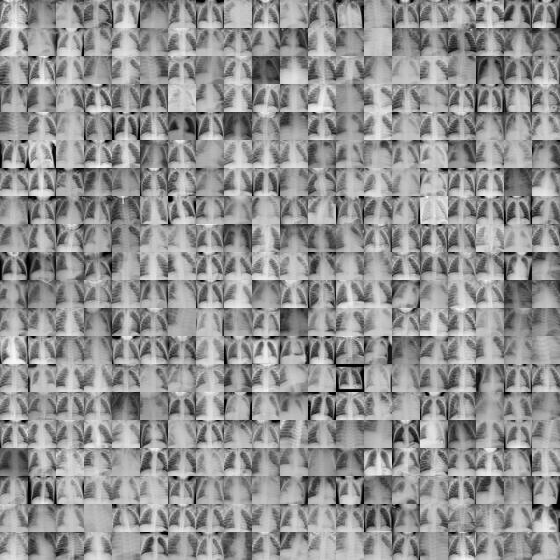

In [5]:
# Let's have a look at some of the training images.
train_dataset.montage(length=20)

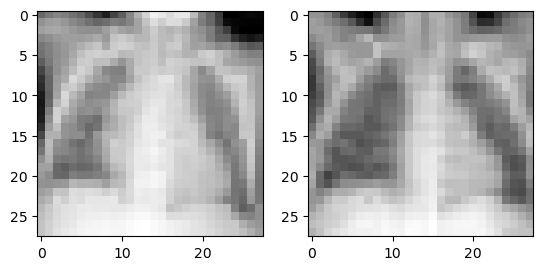

In [6]:
# Let's visually compare pneumial vs. healthy thoraic xray
# 0: normal, 1: pneumonia
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_dataset[0][0], cmap='gray') # pneumonia
ax[1].imshow(train_dataset[200][0],cmap='gray') # normal

### Baseline Model Implementation
To implement the baseline, we start with the [medMNIST github](https://github.com/MedMNIST/MedMNIST), where we can find a [Pytorch getting started notebook](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb).

In [7]:
# We define a simple CNN model for pneumonia classification
from torch import nn

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes-1)) # -1 if we use binary CLF

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Initialization of model, criterion and optimizer

In [8]:
from torch import optim

lr = 0.001

model_base = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_base.parameters(), lr=lr, momentum=0.9)


# 4. Testing the Baseline and Storage of Results


Defining hyperparameters and splitting of the dataset into test, validation, train.

In [9]:
data_flag = 'pneumoniamnist'
download = True  #  set to False if already loaded

NUM_EPOCHS = 5
BATCH_SIZE = 128
#lr = 0.001

info = INFO[data_flag]
#task = info['task']
#n_channels = info['n_channels']
#n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [10]:
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# ingest torch datasets data into torch dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\sergi\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\sergi\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\sergi\.medmnist\pneumoniamnist.npz


Defining evaluation metrics such as the area under the receiver operating characteristic curve (AUROC) and the accuracy (ACC).

In [11]:
def getAUC(y_true, y_score, task):
    '''AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == 'multi-label, binary-class':
        auc = 0
        for i in range(y_score.shape[1]):
            label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
            auc += label_auc
        ret = auc / y_score.shape[1]
    elif task == 'binary-class':
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = roc_auc_score(y_true, y_score)
    else:
        auc = 0
        for i in range(y_score.shape[1]):
            y_true_binary = (y_true == i).astype(float)
            y_score_binary = y_score[:, i]
            auc += roc_auc_score(y_true_binary, y_score_binary)
        ret = auc / y_score.shape[1]

    return ret

def getACC(y_true, y_score, task, threshold=0.5):
    '''Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == 'multi-label, binary-class':
        y_pre = y_score > threshold
        acc = 0
        for label in range(y_true.shape[1]):
            label_acc = accuracy_score(y_true[:, label], y_pre[:, label])
            acc += label_acc
        ret = acc / y_true.shape[1]
    elif task == 'binary-class':
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = accuracy_score(y_true, y_score > threshold)
    else:
        ret = accuracy_score(y_true, np.argmax(y_score, axis=-1))

    return ret

Training the baseline pneumonia classification model.

In [12]:
from tqdm import tqdm

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model_base.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model_base(inputs)

        targets = targets.float()
        outputs = outputs.float()

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:08<00:00,  4.37it/s]


Validation and test of the baseline model. This will let us know how good our model when trained on real data.

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch

# evaluation
def test(split, model):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'val':
        data_loader = val_loader
    else:
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.to(torch.float32)
            outputs = outputs.sigmoid()

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        acc = getACC(y_true, y_score, task)
        auc = getAUC(y_true, y_score, task)

        print('%s  auc: %.3f  acc: %.3f' % (split, auc, acc))
        return acc, auc, y_true


print('==> Evaluating baseline model ...')
acc, auc, y_true = test('train', model_base)
acc, auc, y_true = test('val', model_base)
acc, auc, y_true = test('test', model_base)

==> Evaluating baseline model ...
train  auc: 0.991  acc: 0.951
val  auc: 0.990  acc: 0.954
test  auc: 0.951  acc: 0.812


# 5 Definition and Implementation of our GAN Method

#### GAN Architecture Choice

You may use any GAN architecture and loss function you deem suitable.

To give some guidance, you could try a Deep Convolutional GAN ([DCGAN](https://arxiv.org/abs/1511.06434)). A helpful DCGAN implementation tutorial can be found [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

*Note that you will need to adjust the layers of the network to match the dimensions of the input data.*

DCGAN is an unconditional GAN architecture, which means that the data generation process is not controlled by the label information (pneumonia/normal). Hence, you would need to [extend the DCGAN architecture to a (DC)CGAN](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/) to be able to feed the labels as input into the generator and discriminator.

An alternative to the class-conditional GAN is to train an unconditional GAN twice - once on data with positive label and once on data with negative label.

*Note, instead of CGAN, you could also extend your DCGAN to the [Auxiliary Classifier GAN (ACGAN)] (https://arxiv.org/abs/1610.09585) architecture*.

Also, feel free to optionally use another deep generative model for this task instead of a GAN. For example, here you find a [tutorial](https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/classifier_free_guidance/2d_ddpm_classifier_free_guidance_tutorial.ipynb) for training a class-conditional diffusion model.

In [14]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [15]:
# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28 * 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

# Number of classification classes
num_classes = 2

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [16]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [18]:
# Create networks for normal images
netG_normal = Generator(ngpu).to(device)
netD_normal = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG_normal = nn.DataParallel(netG_normal, list(range(ngpu)))
    netD_normal = nn.DataParallel(netD_normal, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG_normal.apply(weights_init)
netD_normal.apply(weights_init)

# Setup Adam optimizers for both G and D
optimizerD_normal = optim.Adam(netD_normal.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_normal = optim.Adam(netG_normal.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
print("Starting Training Loop For Normal Images...")
for epoch in range(num_epochs):
    for data in train_loader:
        # Filter current batch so that all images have the same label
        batch_labels = data[1]
        real_batch = data[0][batch_labels == 0]  # 0: normal

        # Add a dimension because the channel dimension has been flattened
        real_batch = real_batch.unsqueeze(1)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_normal.zero_grad()
        # Format batch
        real_batch = real_batch.to(device)
        b_size = real_batch.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD_normal(real_batch).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake_batch = netG_normal(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD_normal(fake_batch.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_normal.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_normal.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_normal(fake_batch).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_normal.step()
        
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch+1, num_epochs, errD.item(), errG.item()))

Starting Training Loop For Normal Images...
[1/5]	Loss_D: 0.0520	Loss_G: 4.8280
[2/5]	Loss_D: 0.6700	Loss_G: 8.1446
[3/5]	Loss_D: 5.6025	Loss_G: 1.9074
[4/5]	Loss_D: 0.6240	Loss_G: 6.2895
[5/5]	Loss_D: 0.1853	Loss_G: 4.6996


In [19]:
# Create networks for pneumonia images
netG_pneumo = Generator(ngpu).to(device)
netD_pneumo = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG_pneumo = nn.DataParallel(netG_pneumo, list(range(ngpu)))
    netD_pneumo = nn.DataParallel(netD_pneumo, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG_pneumo.apply(weights_init)
netD_pneumo.apply(weights_init)

# Setup Adam optimizers for both G and D
optimizerD_pneumo = optim.Adam(netD_pneumo.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_pneumo = optim.Adam(netG_pneumo.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
print("Starting Training Loop For Pneumonia Images...")
for epoch in range(num_epochs):
    for data in train_loader:
        # Filter current batch so that all images have the same label
        batch_labels = data[1]
        real_batch = data[0][batch_labels == 1]  # 1: pneumonia

        # Add a dimension because the channel dimension has been flattened
        real_batch = real_batch.unsqueeze(1)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_pneumo.zero_grad()
        # Format batch
        real_batch = real_batch.to(device)
        b_size = real_batch.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD_pneumo(real_batch).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake_batch = netG_pneumo(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD_pneumo(fake_batch.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_pneumo.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_pneumo.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_pneumo(fake_batch).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_pneumo.step()
        
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch+1, num_epochs, errD.item(), errG.item()))

Starting Training Loop For Pneumonia Images...
[1/5]	Loss_D: 0.1056	Loss_G: 4.5727
[2/5]	Loss_D: 0.5302	Loss_G: 2.5438
[3/5]	Loss_D: 1.1405	Loss_G: 1.7551
[4/5]	Loss_D: 0.6757	Loss_G: 1.8190
[5/5]	Loss_D: 0.6398	Loss_G: 2.6038


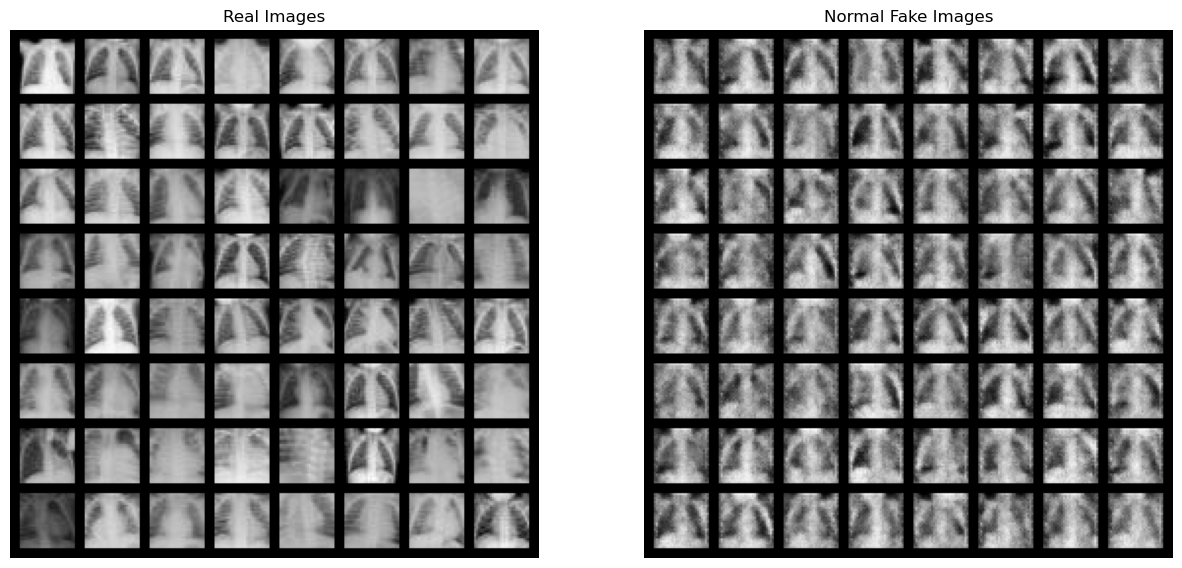

In [20]:
# Grab a batch of real images from our dataloader
real_batch = next(iter(train_loader))

# Create a fake batch of normal images
fake_batch = netG_normal(fixed_noise)

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Normal Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device), padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

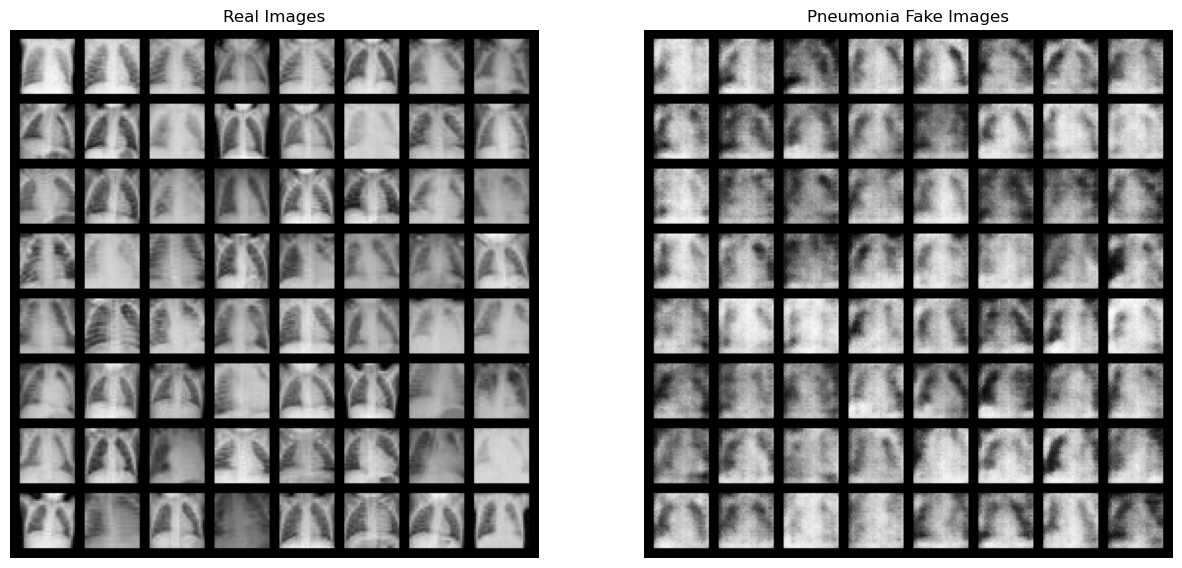

In [21]:
# Grab a batch of real images from our dataloader
real_batch = next(iter(train_loader))

# Create a fake batch of pneumonia images
fake_batch = netG_pneumo(fixed_noise)

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Pneumonia Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device), padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

#### Synthetic Data Evaluation Metric

Given our hypothesis, we need to evaluate the GAN based on the downstream task i.e. the classification performance (AUC, ACC). However, we should also report a fidelity and diversity estimate of our synthetic data. This is not only useful as additional metric, but also as stopping criterion of GAN training (e.g., n epochs without improvement). We propose you use the [Fréchet Inception Distance](https://github.com/mseitzer/pytorch-fid), but feel free to suggest other or additional metrics. Feel free to use existing packages such as the [pytorch-fid](https://pypi.org/project/pytorch-fid/) package.

In [22]:
import os
from PIL import Image
import pytorch_fid


# Define a function to generate fake images from real ones using the GAN generator
def generate_fake_images(data_loader):
    # Initialize lists to store real and fake images depending on the class label
    real_n_images = []
    fake_n_images = []
    real_p_images = []
    fake_p_images = []
    
    for data in data_loader:
        # Filter current batch so that all images of each batch have the same label
        batch_labels = data[1]
        normal_batch = data[0][batch_labels == 0]  # 0: normal
        pneumo_batch = data[0][batch_labels == 1]  # 1: pneumonia
        
        # Add a dimension because the channel dimension has been flattened
        normal_batch = normal_batch.unsqueeze(1)
        pneumo_batch = pneumo_batch.unsqueeze(1)
        
        # Store both lengths of current batches
        n_size = normal_batch.size(0)
        p_size = pneumo_batch.size(0)

        # Generate fake images
        normal_noise = torch.randn(n_size, nz, 1, 1, device=device)
        pneumo_noise = torch.randn(p_size, nz, 1, 1, device=device)
        normal_fake = netG_normal(normal_noise)
        pneumo_fake = netG_pneumo(pneumo_noise)

        # Store real_images and fake_images
        real_n_images.append(normal_batch)
        fake_n_images.append(normal_fake)
        real_p_images.append(pneumo_batch)
        fake_p_images.append(pneumo_fake)

    # Concatenate batches
    real_n_images = torch.cat(real_n_images, dim=0)
    fake_n_images = torch.cat(fake_n_images, dim=0)
    real_p_images = torch.cat(real_p_images, dim=0)
    fake_p_images = torch.cat(fake_p_images, dim=0)

    return real_n_images, fake_n_images, real_p_images, fake_p_images


# Store images in a folder given a tensor with images and the path
def save_images_to_folder(images_tensor, folder_path):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Convert the tensor of images to NumPy arrays
    images_array = images_tensor.detach().cpu().numpy()  # Detach the tensor before converting to NumPy array

    # Iterate over the images and save them as PNG files
    for i, image_array in enumerate(images_array):
        # Ensure the image array has the correct dimensions (H x W x C)
        if image_array.shape[0] == 1:
            # If the image is grayscale, remove the channel dimension
            image_array = image_array.squeeze(0)

        # Convert the numpy array to a PIL image
        image = Image.fromarray(np.uint8(image_array * 255))  # Assuming image values are normalized

        # Save the image as a PNG file
        image_path = os.path.join(folder_path, f'image_{i}.png')
        image.save(image_path)

        
# Store real and fake images in a folder given the split
def generate_and_store(split):
    # Load real images and create fake ones
    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'val':
        data_loader = val_loader
    else:
        data_loader = test_loader
        
    real_n_images, fake_n_images, real_p_images, fake_p_images = generate_fake_images(data_loader)
    real_images = torch.cat((real_n_images, real_p_images), dim=0)
    fake_images = torch.cat((fake_n_images, fake_p_images), dim=0)
    
    # Store images in both tensors in different folders
    save_images_to_folder(real_images, './data/real_' + split)
    save_images_to_folder(fake_images, './data/fake_' + split)
    
    print("Images stored successfully!")

    
# Store in folders real and fake images for our test set for both image classes
generate_and_store('test')

Images stored successfully!


In [34]:
!python -m pytorch_fid "./data/real_test" "./data/fake_test"  # It slows down too much

FID:  134.54188073857415



100%|##########| 13/13 [01:06<00:00,  5.11s/it]

100%|##########| 13/13 [01:02<00:00,  4.79s/it]


# 6. Test of our GAN Method and Storage of Results

Now that you have trained your GAN, it is time for the big moment of testing our hypothesis. To do so, a balanced classifier training dataset (50% pneumonia, 50% normal) consisting only of synthetic data is suggested. You may sample this dataset from your trained conditional generator, store on disc and load it again here.

In [24]:
# Used to store data in disk when required
def store_training_in_disk():
    # Initialize two lists to store generated images
    normal_images = []
    pneumo_images = []
    
    # Get 3 sets of fake images so that we have enough data
    for i in range(3):
        _, fake_n_images, _, fake_p_images = generate_fake_images(train_loader_at_eval)
        
        # Append new sets
        normal_images.append(fake_n_images)
        pneumo_images.append(fake_p_images)
    
    # Concatenate sets of data and convert to a tensor
    normal_images = torch.cat(normal_images, dim=0)
    pneumo_images = torch.cat(pneumo_images, dim=0)
    
    # Length matching
    min_length = min(len(normal_images), len(pneumo_images))
    normal_images = normal_images[:min_length]
    pneumo_images = pneumo_images[:min_length]
    
    # Save tensors to disk
    torch.save(normal_images, './data/training_normal_images.pt')
    torch.save(pneumo_images, './data/training_pneumonia_images.pt')

# Generate data when needed, set flag to False
load_flag_tensor = True

if not load_flag_tensor:
    store_training_in_disk_tensor()

In [25]:
# read data from disc (maybe also check dimensions)
generated_imgs_w_label_0 = torch.load('./data/training_normal_images.pt')  # 0: normal
generated_imgs_w_label_1 = torch.load('./data/training_pneumonia_images.pt')  # 1: pneumonia

# your code here
print("Normal images shape:", generated_imgs_w_label_0.shape)
print("Pneumonia images shape:", generated_imgs_w_label_1.shape)


# Now we are going to combine both tensors in a single one, with its labels placed appropriately
from torch.utils.data import TensorDataset

images = torch.cat((generated_imgs_w_label_0, generated_imgs_w_label_1), dim=0)
labels = torch.cat((torch.zeros(generated_imgs_w_label_0.shape[0]), torch.ones(generated_imgs_w_label_1.shape[0])))

# Create a TensorDataset
train_gen_dataset = TensorDataset(images, labels)

# Check the length of the combined dataset
print("Combined dataset length:", len(train_gen_dataset))

# Accessing data from the combined dataset
image, label = train_gen_dataset[0]
print("Image shape:", image.shape)
print("Label:", label)

Normal images shape: torch.Size([3642, 1, 28, 28])
Pneumonia images shape: torch.Size([3642, 1, 28, 28])
Combined dataset length: 7284
Image shape: torch.Size([1, 28, 28])
Label: tensor(0.)


Below some helper code to help define a torch CustomImageDataset Class based on the generated images that are loaded from disc.

In [26]:
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, imgs_label_0, imgs_label_1, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame(
            np.concatenate((np.zeros(len(imgs_label_0), dtype=int),
                            np.ones(len(imgs_label_1), dtype=int)))
        )
        self.images = np.concatenate((imgs_label_0, imgs_label_1))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx])
        label = np.array([self.img_labels.iloc[idx, 0]])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [27]:
# Create torch dataset with generated images
#train_gen_dataset = CustomImageDataset(generated_imgs_w_label_0, generated_imgs_w_label_1)
# Create torch dataloader
#train_gen_loader = DataLoader(dataset=train_gen_dataset, batch_size=BATCH_SIZE, shuffle=True)

# As we already created a TensorDataset, we generate the DataLoader directly from it
train_gen_loader = DataLoader(dataset=train_gen_dataset, batch_size=BATCH_SIZE, shuffle=True)

Training of the classifier, as was done above with real data, but now with the generated dataset.

In [28]:
# Your code goes here.

# Initialize model_base
lr = 0.001
model_gen = Net(in_channels=n_channels, num_classes=n_classes)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_gen.parameters(), lr=lr, momentum=0.9)

# Train as in baseline model
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model_gen.train()
    for inputs, targets in tqdm(train_gen_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model_gen(inputs)
        
        targets = targets.float().unsqueeze(1) # match dimensions
        outputs = outputs.float()
        
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:45<00:00,  1.25it/s]


Test of the classifier, as was done above with real data, but now with the generated dataset.

In [29]:
# your code here

# To enable fair comparisons, we evaluate the model in the same way as in the baseline
print('==> Evaluating baseline model with generated data ...')
acc, auc, y_true = test('train', model_gen)
acc, auc, y_true = test('val', model_gen)
acc, auc, y_true = test('test', model_gen)

==> Evaluating baseline model with generated data ...
train  auc: 0.949  acc: 0.901
val  auc: 0.945  acc: 0.897
test  auc: 0.878  acc: 0.821


# 7. Comparison of our Method and Baseline, Interpretration of Results

You may use some visualization techniques here to compare the baseline (i) with your method (ii). For example, it would be interesting to plot both ROC-AUC curves to visually compare them. Another visualization option is a confusion matrix for (i) and (ii).

In [32]:
# example function for plotting multiple ROC-AUC curve in one figure.
def plot_roc_cur(fpr1, tpr1, fpr2, tpr2, auc1, auc2, model_name):
    plt.plot(fpr1, tpr1, color='orange', label='Classifier 1 (AUROC = %0.3f)' % auc1)
    plt.plot(fpr2, tpr2, color='gray', label='Classifier 2 (AUROC = %0.3f)' % auc2)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve {}'.format(model_name))
    plt.legend()
    plt.show()

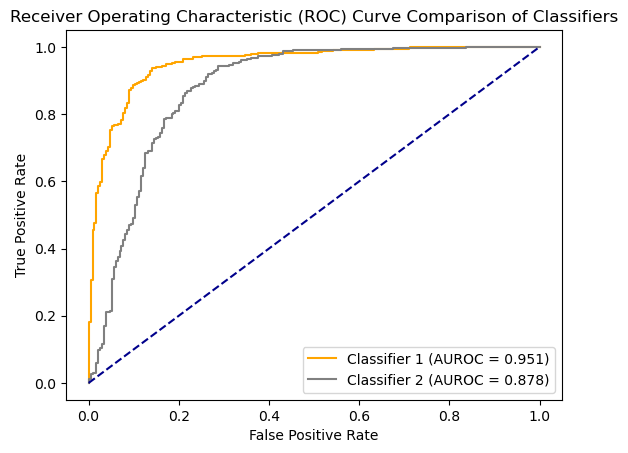

In [33]:
# Your code goes here.

# Same evaluation function, modified to also output y_score
def test_extended(split, model):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'val':
        data_loader = val_loader
    else:
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.to(torch.float32)
            outputs = outputs.sigmoid()

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        acc = getACC(y_true, y_score, task)
        auc = getAUC(y_true, y_score, task)

        return acc, auc, y_true, y_score
    
    
from sklearn.metrics import roc_curve, auc

# Extend the test method to return the predicted scores
acc1, auc1, y_true1, y_score1 = test_extended('test', model_base)
acc2, auc2, y_true2, y_score2 = test_extended('test', model_gen)

# Compute both false positive rate and true positive rate for each classifier
fpr1, tpr1, _ = roc_curve(y_true1, y_score1)
fpr2, tpr2, _ = roc_curve(y_true2, y_score2)

# Plot the results
plot_roc_cur(fpr1, tpr1, fpr2, tpr2, auc1, auc2, "Comparison of Classifiers")

How would you interpret the results you achieved? Would you say your GAN-based privatization method is useful in practice? Do you reject or accept the hypothesis defined above?

#### ANSWER:

The model performs performs a little worse with our augmented synthetic data than with the real one, which means our synthetic images is not as good as the real one but could also be used for the same purposes. As the metrics for our generated data are quite high to be considered an accurate classification, it has been proved our GAN-based privatization method could be implemented in practical scenarios. Overall, we conclude we should accept the hypothesis, which is undeniable from the results obtained. Hence, there are two practical advantages in using synthetic data over real one, the possibility of augmenting the data size and its privatization. Consequently, the results make a huge impact in privacy preserving in such an important domain as health.

# 8. Reflective Account

What could be the reasons why our study did or did not succeed? What do you think are the limitations of our study? What can we learn and takeaway from this exercise? How should it inform our future work? What would you try next?

#### ANSWER:

The study concluded successfully, the main reasons for this are the implementation of two different GANs (which each one learn the representation of a different image class) and the decision of loading the tensors of images directly. I first tried to store the generated images and then use the given class to generate the dataloader, but decided against it while I compared the results, revealing a huge speed-up from the current approach when compared to the proposed one.

I think the study is very interesting, as it forces you to comprehend how GANs are used and how to generate synthetic data for privacy preservation tasks. Nonetheless, I would like to test my solution with different test sets, as perhaps we are not generalizing quite enough because our real data comes from controled population which does not represent everybody.

Still, as I already said, this exercise is useful for introducing ourselves how GANs are used in the health domain for privacy preservation tasks, which is considered essential nowadays.

For future work, I would check if the synthetic data matches the distribution of the whole population. If that is not the case, I would try to generate different synthetic data for each population subgroup, increasing therefore the accuracy of the method. I believe this work opens up a wide variety of study lines, but first and foremost I would stuck with improving the accuracy for all population subgroups, leading to a fairer and more ethical algorithm.

Thank you for working on this study. We hope you enjoyed it and it was a good learning experience for you.

Please send any feedback you may have to [Richard.Osuala@ub.edu](mailto:Richard.Osuala@ub.edu).